# Face Detection with Haar Cascades

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## Images

In [2]:
girl = cv2.imread('test_img/test_nomask_1.jpeg', 0)
guy = cv2.imread('test_img/unsplash.jpg', 0)
group = cv2.imread('test_img/group_nomask.jpg', 0)

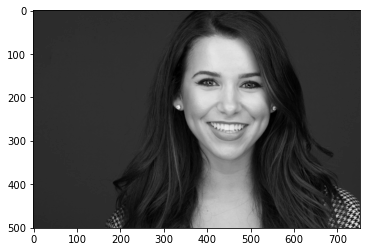

In [3]:
plt.imshow(girl,cmap='gray')

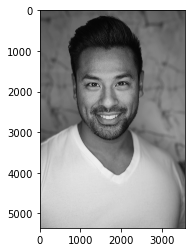

In [4]:
plt.imshow(guy,cmap='gray')

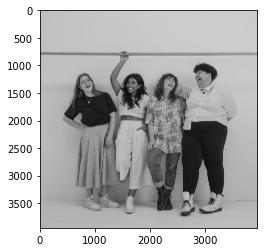

In [5]:
plt.imshow(group,cmap='gray')

## Resize image

In [6]:
# resize images for later on
print('Original Dimensions : ',girl.shape)
desired_height=1000
img_height = girl.shape[1]
scale = desired_height / img_height
# scale_percent = 60 # percent of original size
width = int(girl.shape[1] * scale)
height = int(girl.shape[0] * scale)
dim = (width, height)
  
# resize image
resized = cv2.resize(girl, dim, interpolation = cv2.INTER_AREA)
 
print('Resized Dimensions : ',resized.shape)
 
cv2.imshow("Resized image", resized)

Original Dimensions :  (501, 752)
Resized Dimensions :  (666, 1000)


In [7]:
def resize_img(img):
    desired_height=1000
    img_height = img.shape[1]
    scale = desired_height / img_height
    width = int(img.shape[1] * scale)
    height = int(img.shape[0] * scale)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

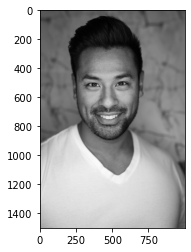

In [8]:
plt.imshow(resize_img(guy),cmap='gray')

## Cascade File for Face Detection
.xml files downloaded from [here](https://github.com/opencv/opencv/tree/master/data/haarcascades)

In [9]:
# Load the cascade
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

## Detect face functions

In [10]:
def detect_face(img):
    
    face_img = img.copy()
    face_img = cv2.cvtColor(face_img, cv2.IMREAD_GRAYSCALE) #convert to grayscale for cascade
    face_rects = face_cascade.detectMultiScale(face_img)
    out_img = cv2.cvtColor(face_img, cv2.COLOR_RGB2BGR) #convert back to BGR layout for plt
    
    for (x,y,w,h) in face_rects:
        cv2.rectangle(out_img, (x,y), (x+w,y+h), (255,255,255), 10)
    
    return out_img

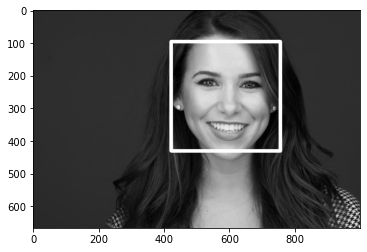

In [11]:
resized = resize_img(girl)
result = detect_face(resized)
plt.imshow(result,cmap='gray')

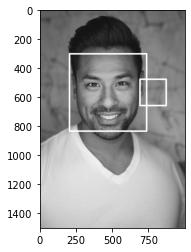

In [12]:
resized = resize_img(guy)
result = detect_face(resized)
plt.imshow(result,cmap='gray')

Getting error

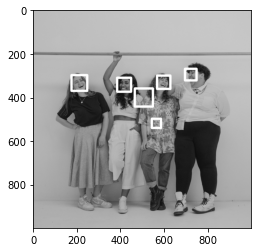

In [13]:
resized = resize_img(group)
result = detect_face(resized)
plt.imshow(result,cmap='gray')

Getting errors! Detection too sensitive

In [14]:
def adj_detect_face(img):
    face_img = img.copy()
    face_img = cv2.cvtColor(face_img, cv2.IMREAD_GRAYSCALE) #convert to grayscale for cascade
    face_rects = face_cascade.detectMultiScale(face_img, scaleFactor=1.2, minNeighbors=6)
    out_img = cv2.cvtColor(face_img, cv2.COLOR_RGB2GRAY) #convert back to BGR layout for plt
    out_img = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
    for (x,y,w,h) in face_rects:
        cv2.rectangle(out_img, (x,y), (x+w,y+h), (255,255,255), 10)
    
    plt.imshow(out_img)

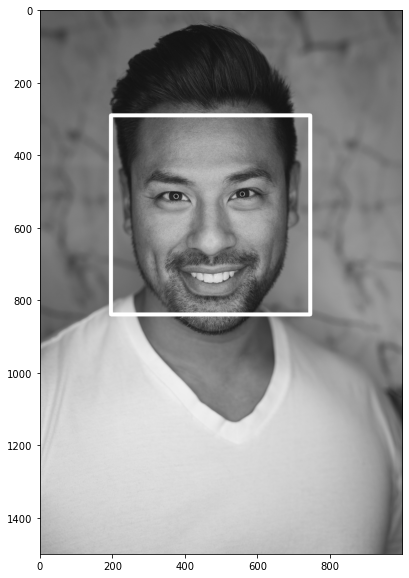

In [15]:
plt.figure(figsize=(10,10))
resized = resize_img(guy)
result = adj_detect_face(resized)
# plt.imshow(result)

Better this time!

In [17]:
# resized = resize_img(group)
# result = adj_detect_face(resized)
# plt.imshow(result,cmap='gray');

Noice!

In [ ]:
# webcam video detect
# cap = cv2.VideoCapture(0)
# while True:
#     ret, frame = cap.read(0)
    
#     frame = adj_detect_face(frame)
    
#     cv2.imshow('Video Face Detection',frame)
    
#     c = cv2.waitKey(1)
#     if c ==27:
#         break
# cap.release()
# cv2.destroyAllWindows()
# cv2.waitKey(1)
# #use esc key to exit

## Face mask detector

In [18]:
from scipy.spatial import distance
from keras.models import load_model
model = load_model('binary_model.h5')

In [19]:
def resize_img(img):
    desired_height=1000
    img_height = img.shape[0]
    scale = desired_height / img_height
    width = int(img.shape[1] * scale)
    height = int(img.shape[0] * scale)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

In [39]:
def face_mask_detector(img, model):
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

    faces = face_cascade.detectMultiScale(img,scaleFactor=1.1, minNeighbors=8)
    
    MIN_DISTANCE = 0
    
    if len(faces) > 0:
        label = [0 for i in range(len(faces))]
        for i in range(len(faces)-1):
            for j in range(i+1, len(faces)):
                dist = distance.euclidean(faces[i][:2],faces[j][:2])
                if dist<MIN_DISTANCE:
                    label[i] = 1
                    label[j] = 1
        
        out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
        # resize image
        desired_height=1000
        img_height = img.shape[0]
        scale = desired_height / img_height
        width = int(img.shape[1] * scale)
        height = int(img.shape[0] * scale)
        dim = (width, height)
        out_img = cv2.resize(out_img, dim, interpolation = cv2.INTER_AREA)
        
        for i in range(len(faces)):
            (x,y,w,h) = faces[i]
            x, y, w, h = int(x * scale), int(y * scale), int(w * scale), int(h * scale)
            
            crop = out_img[y:y+h,x:x+w]
            crop = cv2.resize(crop,(150,150))
            crop = np.reshape(crop,[1,150,150,3])/255.0
            mask_result = model.predict_classes(crop)
            
            if mask_result == 0:
                cv2.putText(out_img,"With Mask",(x, y-10), cv2.FONT_HERSHEY_DUPLEX,1,(102,204,0),2)
                cv2.rectangle(out_img,(x,y),(x+w,y+h),(102,204,0),5)
            elif mask_result == 1:
                cv2.putText(out_img,"No Mask",(x, y-10), cv2.FONT_HERSHEY_DUPLEX,1,(255,51,51),2)
                cv2.rectangle(out_img,(x,y),(x+w,y+h),(255,51,51),5)                
        
        plt.figure(figsize=(10,10))
        plt.imshow(out_img)

    else:
        print("No Face!")

## No Mask

/Users/crystalhuang/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


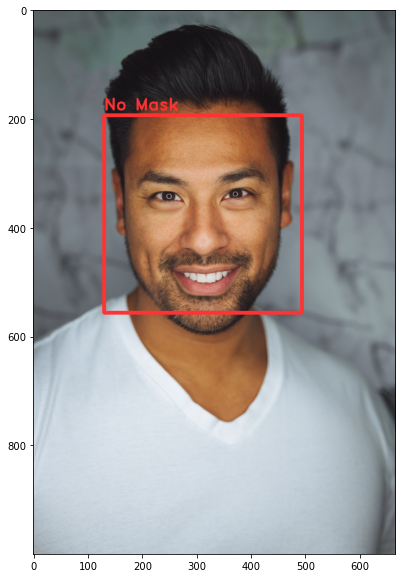

In [21]:
img = cv2.imread('test_img/unsplash.jpg')
face_mask_detector(img, model)

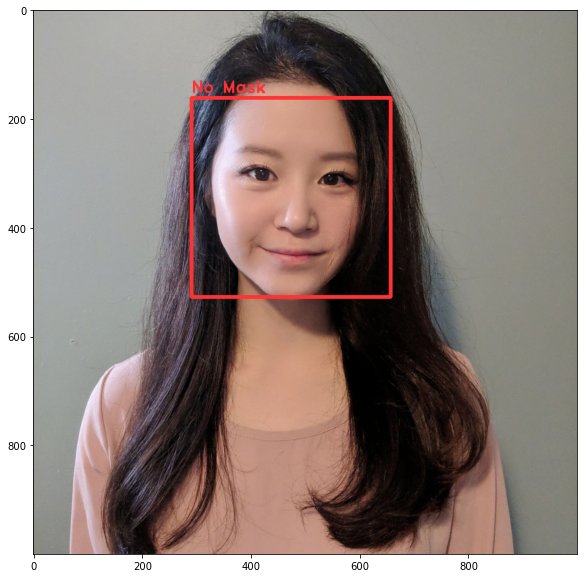

In [22]:
img = cv2.imread('test_img/self/test.jpg')
face_mask_detector(img, model)

## With Mask

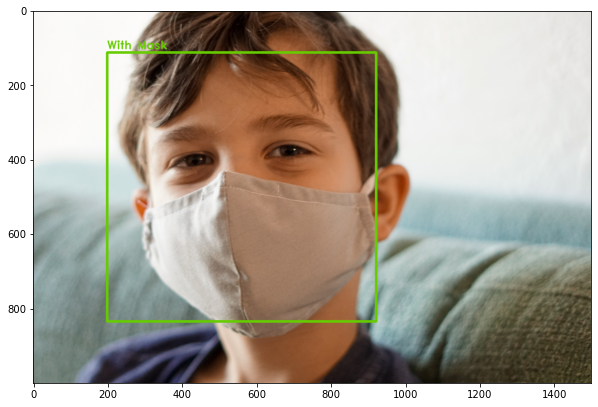

In [23]:
img = cv2.imread('test_img/test_mask _1.jpg')
face_mask_detector(img, model)

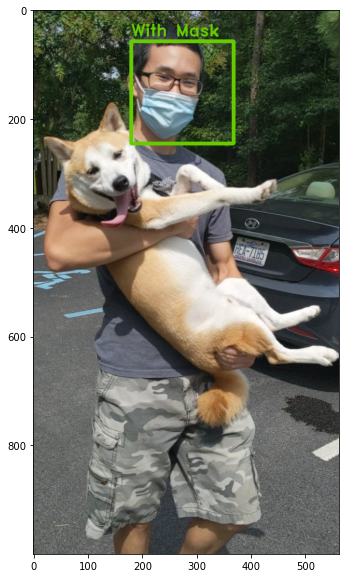

In [24]:
img = cv2.imread('test_img/test_mask_5.jpg')
face_mask_detector(img, model)

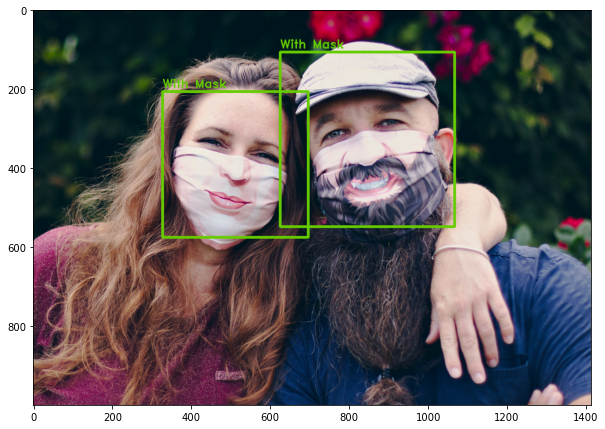

In [25]:
img = cv2.imread('test_img/group_mask2.jpg')
face_mask_detector(img, model)

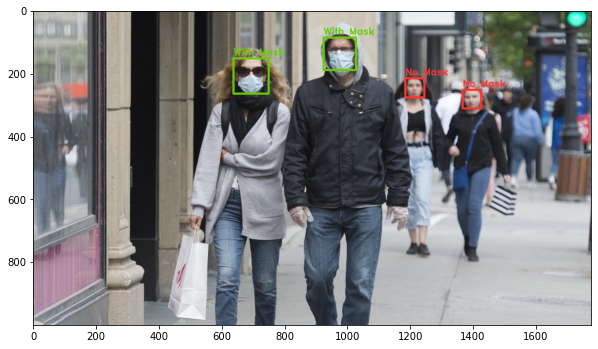

In [26]:
img = cv2.imread('test_img/group_mix.jpeg')
face_mask_detector(img, model)

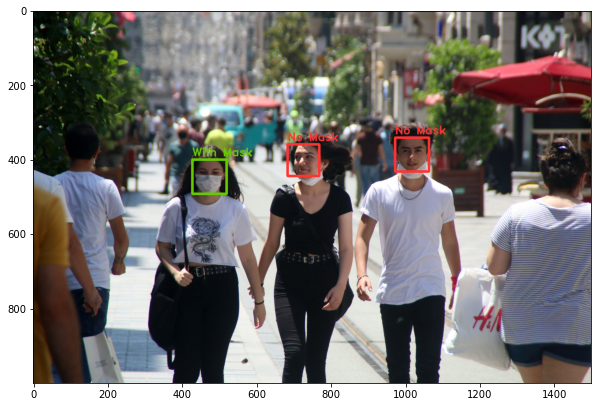

In [27]:
img = cv2.imread('test_img/group_mix3.jpeg')
face_mask_detector(img, model)

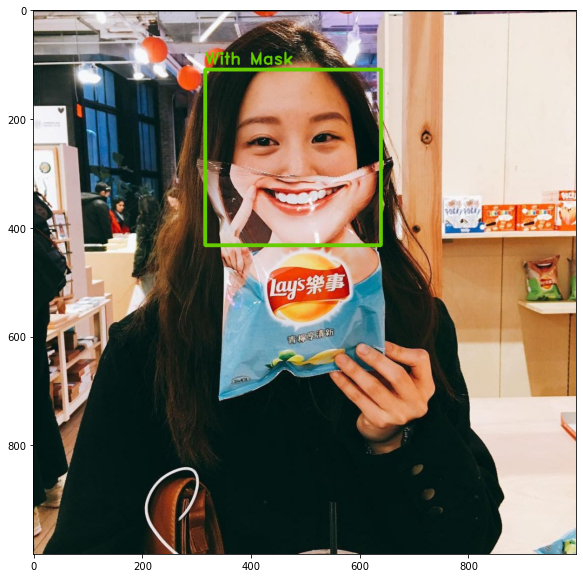

In [28]:
img = cv2.imread('test_img/self/test3.jpg')
face_mask_detector(img, model)

All did pretty well except the last one! (Mistaken the chip bag as mask)

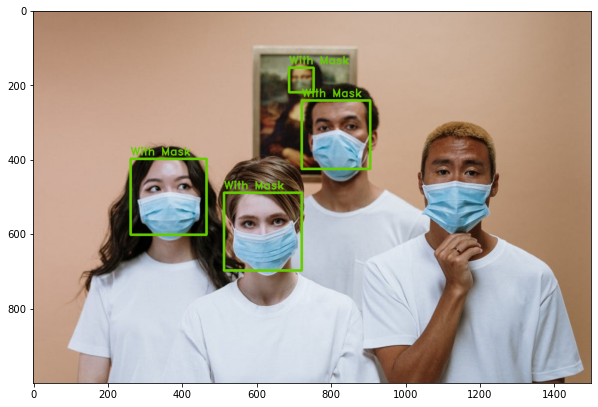

In [41]:
img = cv2.imread('test_img/new/0072.jpg')
face_mask_detector(img, model)

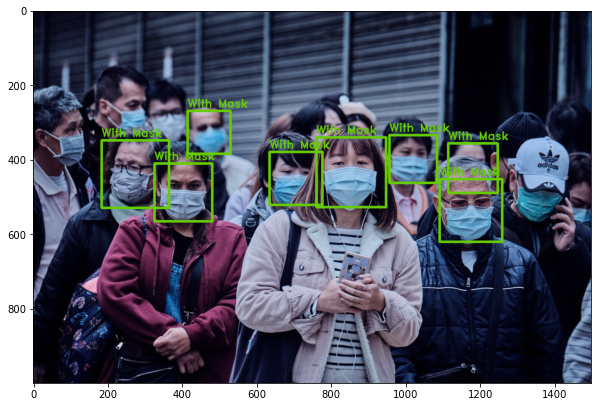

In [30]:
img = cv2.imread('test_img/new/0623.jpg')
face_mask_detector(img, model)

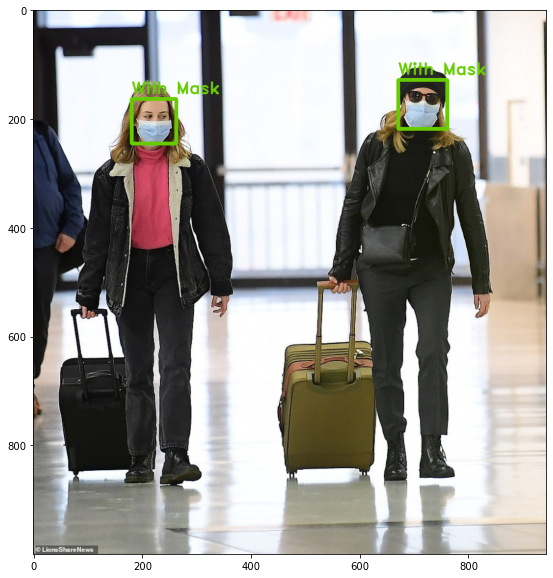

In [31]:
img = cv2.imread('test_img/new/0402.jpg')
face_mask_detector(img, model)

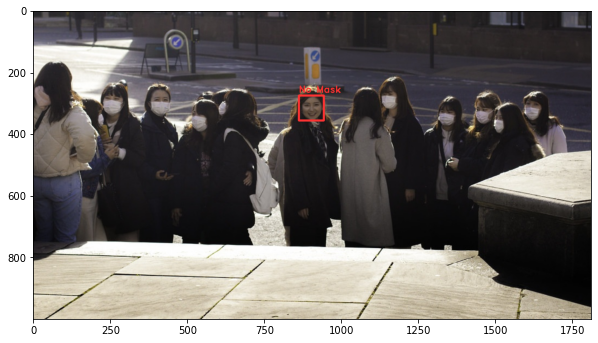

In [32]:
img = cv2.imread('test_img/new/0689.jpg')
face_mask_detector(img, model)

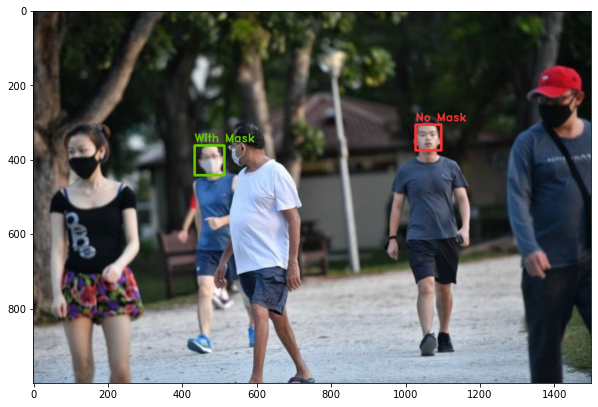

In [35]:
img = cv2.imread('test_img/new/0360.jpg')
face_mask_detector(img, model)